In [1]:
%matplotlib widget
import numpy as np
import json, os, glob, numbers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *

import warnings
warnings.filterwarnings('ignore')

<a id='averaged_XAS'></a>
## Load data

In [2]:
pgroup = 'p22250'
Loaddir_name = ''

#runlist = np.arange(41, 45)
#runlist = [205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246]
runlist = [322,323,324]
t0_offsets = [0]*len(runlist)
#t0_offsets = offset #[0]*len(runlist)
#t0_offsets = t0_offsets #[0]*len(runlist)     # old, not to be used

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
#Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

In [3]:
#Plot_correlations_scan(pgroup, Loaddir, runlist, path='raw', timescan=False, lowlim = 0.90)
#Plot_scan_2diodes(pgroup, Loaddir, runlist, path='raw', timescan=False)
#t0_offsets

Run 322, Delays_stage offset by 0 fs
Run 322, Delays_corr offset by 0 fs
Run 323, Delays_stage offset by 0 fs
Run 323, Delays_corr offset by 0 fs
Run 324, Delays_stage offset by 0 fs
Run 324, Delays_corr offset by 0 fs
[322, 323, 324]


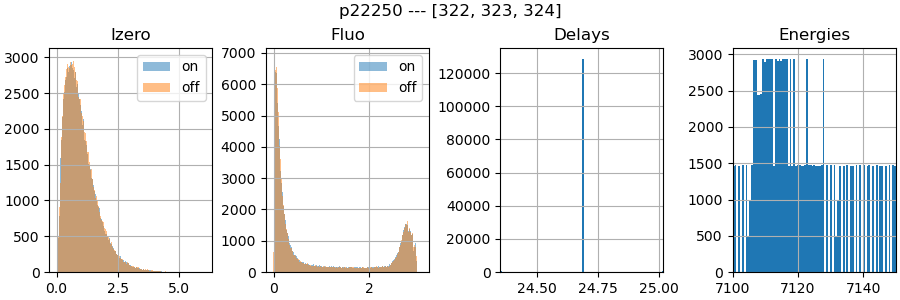

Time delay axis rebinned with delay stage data
(3, 89)


In [4]:
average_twodiodes = False
withTT = False

switch_diodes = True   #False #False for Diode 1, True for diode 2

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
#Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
#firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

#data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist, average_twodiodes, switch_diodes)
data, titlestring_stack = load_reduced_data_offset(pgroup, Loaddir, runlist, t0_offsets, average_twodiodes, switch_diodes)
#data, titlestring_stack = load_reduced_data_noPair(pgroup, Loaddir, runlist, average_twodiodes)

globals().update(data)
print (runlist)
#print ('{} scan(s), {laser.delay.pumpprobe} total on/off shots'.format(len(runlist), len(pump_1)))

Plot_reduced_data(data, scan, titlestring_stack, withTT)

pump_1       = np.asarray(pump_1)
unpump_1     = np.asarray(unpump_1)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
energy       = np.asarray(energy)
Delays_corr  = np.asarray(Delays_corr)
readbacks    = np.asarray(readbacks, dtype=object)

print (np.shape(readbacks))

## [1D scan - fix delay](#1D-scan)
## [2D scan - delay & energy scan](#2D-scan)
## [Overlay curves](#Overlay-data)

# 1D scan

In [5]:
quantile = 0.8

##############################################

rbk = np.array(readbacks[0], dtype=float)

pp, GS, ES, err_pp, err_GS, err_ES, err_pp2, err_GS2, err_ES2, _ = \
Rebin_and_filter_energyscans_PP(data, quantile, rbk, threshold=0, raw=True)

266 89 267
76520 shots out of 130564 survived


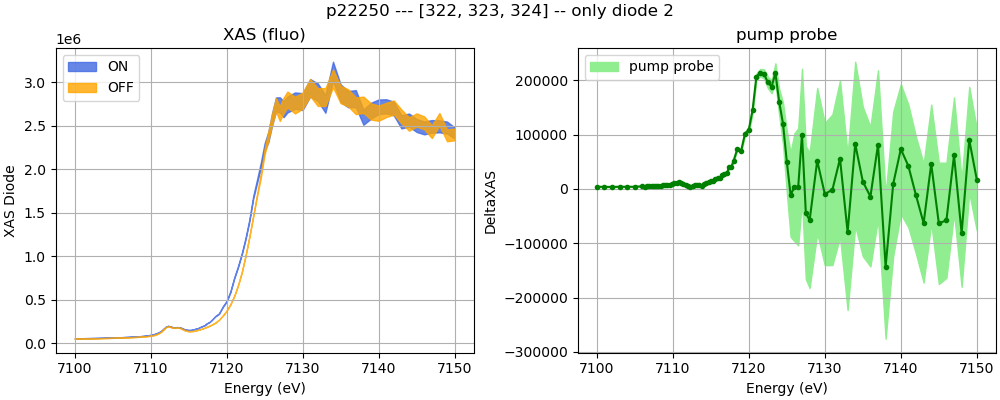

In [6]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle(titlestring_stack+' -- only diode 1')
if average_twodiodes:
    plt.suptitle(titlestring_stack+' -- 2diodes')
if switch_diodes:
    plt.suptitle(titlestring_stack+' -- only diode 2')
    
ax1.fill_between(rbk, ES-err_ES, ES+err_ES, label='ON', color='royalblue', alpha = 0.8)
ax1.fill_between(rbk, GS-err_GS, GS+err_GS, label='OFF',color='orange', alpha = 0.8)
ax3.fill_between(rbk, pp-err_pp, pp+err_pp, label='pump probe',color='lightgreen')
#ax3.fill_between(rbk, pp-err_pp2, pp+err_pp2, label='pump probe',color='lightgreen')
ax3.plot(rbk, pp, color='green', marker='.')

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel ("DeltaXAS")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

plt.show()

## Claudio tests

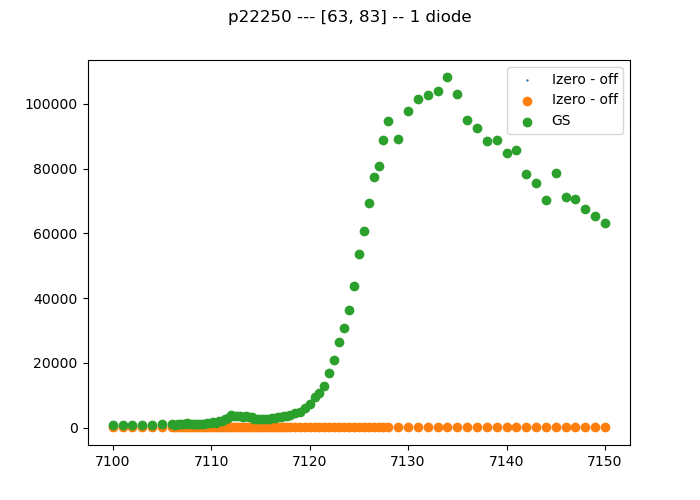

In [35]:
GS = np.array(data['unpump_1_raw'])
GS2 = np.array(data['unpump_2_raw'])
Izero_unpump = np.array(data['Izero_unpump'])
energy = np.array(data['energypad'])
readbacks    = np.asarray(readbacks, dtype=object)

ordered = np.argsort(np.asarray(energy))
peaks, what = find_peaks(np.diff(energy[ordered]))

Izero_unpump = Izero_unpump[ordered]

starts = np.append(0, peaks)
ends = np.append(peaks, None)

I0u = []
G = []

for s, e in zip(starts, ends):
    Izero_p = Izero_unpump[s:e]
    GSs = GS[s:e]
    I0u.append(np.mean(Izero_p))
    G.append(np.mean(GSs))

plt.figure(figsize=(7,5))
plt.suptitle(titlestring_stack+' -- 1 diode')
plt.scatter (energy, Izero_unpump, label='Izero - off', s=0.5)
plt.scatter(readbacks, I0u, label='Izero - off')
plt.scatter(readbacks, G, label='GS')
#plt.scatter(readbacks, np.array(G)/np.array(I0u), label='GS norm')
plt.legend(loc='best')
plt.show()

In [42]:
GS128 = np.copy(GS)

NameError: name 'GS126' is not defined

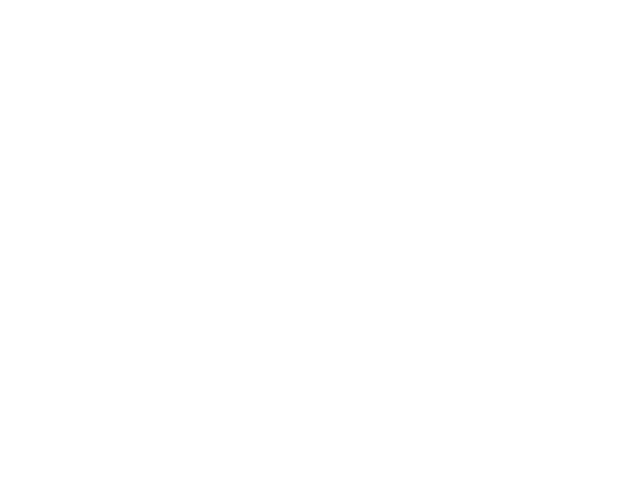

In [43]:
plt.figure()
#plt.hist(GS, bins=100)
#plt.plot(GS/np.mean(GS))
plt.plot(GS126, label = '166', alpha = 0.5)
plt.plot(GS127, label = '167', alpha = 0.5)
plt.plot(GS128, label = '168', alpha = 0.5)

#plt.plot(GS2)
plt.show()

## save the averaged spectra

In [16]:
if switch_diodes == False:
    SaveAveDir = Loaddir+'_averaged/'

    runlist2save = '_'.join(str(x) for x in runlist)
    print (runlist2save)

    check = isinstance(runlist2save, numbers.Number)
    if check:
        run2save = 'run{:04d}'.format(runlist2save)
    else:
        run2save = 'run{}'.format(runlist2save)
    savedir = SaveAveDir+run2save
    os.makedirs(savedir, exist_ok=True)
    run_array = {}
    run_array[run2save] = {"name": run2save,
                           "ES": ES, 
                           "err_ES": err_ES,
                           "GS": GS,
                           "err_GS": err_GS,
                           "pp": pp,
                           "err_pp": err_pp,
                           "readbacks": rbk
                          }
    np.save(savedir+'/run_array', run_array)
    print('Data saved in {}/'.format(savedir))

else:
    SaveAveDir = Loaddir+'_averaged_2/'

    runlist2save = '_'.join(str(x) for x in runlist)
    print (runlist2save)

    check = isinstance(runlist2save, numbers.Number)
    if check:
        run2save = 'run{:04d}'.format(runlist2save)
    else:
        run2save = 'run{}'.format(runlist2save)
    savedir = SaveAveDir+run2save
    os.makedirs(savedir, exist_ok=True)
    run_array = {}
    run_array[run2save] = {"name": run2save,
                           "ES": ES, 
                           "err_ES": err_ES,
                           "GS": GS,
                           "err_GS": err_GS,
                           "pp": pp,
                           "err_pp": err_pp,
                           "readbacks": rbk
                          }
    np.save(savedir+'/run_array', run_array)
    print('Data saved in {}/'.format(savedir))

    # Fred - to save as csv
import pandas as pd

SaveAveDir = Loaddir + '_averaged_2/'

runlist2save = '_'.join(str(x) for x in runlist)
print(runlist2save)

check = isinstance(runlist2save, numbers.Number)
if check:
    run2save = 'run{:04d}'.format(runlist2save)
else:
    run2save = 'run{}'.format(runlist2save)
    
savedir = SaveAveDir + run2save
os.makedirs(savedir, exist_ok=True)

# Create DataFrame
df = pd.DataFrame({
    "name": [run2save],
    "ES": [ES], 
    "err_ES": [err_ES],
    "GS": [GS],
    "err_GS": [err_GS],
    "pp": [pp],
    "err_pp": [err_pp],
    "readbacks": [rbk]
})

# If ES, GS, etc. are arrays and you want them in separate rows:
df = pd.DataFrame({
     "ES": ES, 
     "err_ES": err_ES,
     "GS": GS,
     "err_GS": err_GS,
     "pp": pp,
     "err_pp": err_pp,
     "readbacks": rbk
 })

# Save to CSV
csv_file = os.path.join(savedir, 'run_data.csv')
df.to_csv(csv_file, index=False)

print('Data saved in {}/run_data.csv'.format(savedir))

322_323_324
Data saved in /sf/alvra/data/p22250/work/Reduced_data//_averaged_2/run322_323_324/
322_323_324
Data saved in /sf/alvra/data/p22250/work/Reduced_data//_averaged_2/run322_323_324/run_data.csv


In [8]:
Loaddir

'/sf/alvra/data/p22250/work/Reduced_data//'

# 2D scan

In [561]:
quantile = 0.7

withTT = True

binsize = 10
min_delay = -100
max_delay = 200

(variable_bins_delay, numbins) = (False, 100)

##############################################
rbk = np.array(readbacks[0], dtype=float)

pp_TT, err_pp, GS, ES, Delay_fs_TT, howmany = \
Rebin_and_filter_2Dscans(data, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=3, varbin_t=variable_bins_delay, numbins=numbins)

#pp_TT, GS, ES, err_pp, Delay_fs_TT, howmany = \
#Rebin_and_filter_2Dscans_noPair(data, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.05, varbin_t=variable_bins_delay, numbins=numbins)

2759 69 29
Time delay axis rebinned with TT data
536046 shots out of 1349944 survived (39.71%)


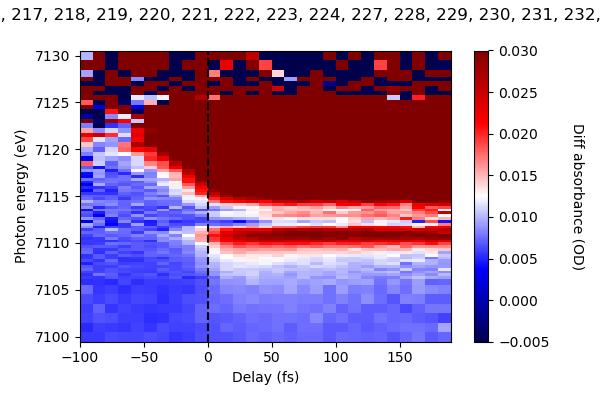

In [562]:
baseline = np.average(pp_TT[:,0:2], axis=1)
#baseline = np.average(GS[:,0:2], axis=1)
baseline = 0 #baseline[:, np.newaxis]

# Delay_fs_TT_2 = Delay_fs_TT[~np.isnan(Delay_fs_TT)]
# pp_TT = pp_TT[:,~np.isnan(Delay_fs_TT)]

plt.figure(figsize=(6, 4))
#plt.rcParams.update({'font.size': 15})
plt.suptitle(titlestring_stack)
#plt.title(runlist)

vmin = -0.005
vmax = 0.03
n = 30
levels = np.linspace(vmin, vmax, n+1)

plt.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='seismic',vmin=vmin, vmax=vmax)
#plt.contourf(pp_TT-baseline, cmap='seismic', levels=levels, extent=[Delay_fs_TT[0], Delay_fs_TT[-1], rbk[0], rbk[-1]], extend='both')
#plt.pcolormesh(Delay_fs_TT+0, rbk, ES-baseline, cmap='jet')#, vmin=-0.004, vmax = 0.011)

#plt.pcolormesh(pp_TT-baseline, cmap='bwr', vmin=-0.1, vmax = 0.1)
#plt.ylabel('{} ({})'.format(_averagedscan.parameters['name'][0],scan.parameters['units'][0]))
plt.ylabel('Photon energy (eV)')

cbar = plt.colorbar(fraction=0.15)
cbar.set_label('Diff absorbance (OD)', rotation=270, labelpad=25)
#plt.colorbar()

plt.xlabel('Delay (fs)')
plt.axvline(x = 0, color = 'k', linestyle = '--')
#plt.grid()
plt.tight_layout()
plt.show()

9
10
12
16


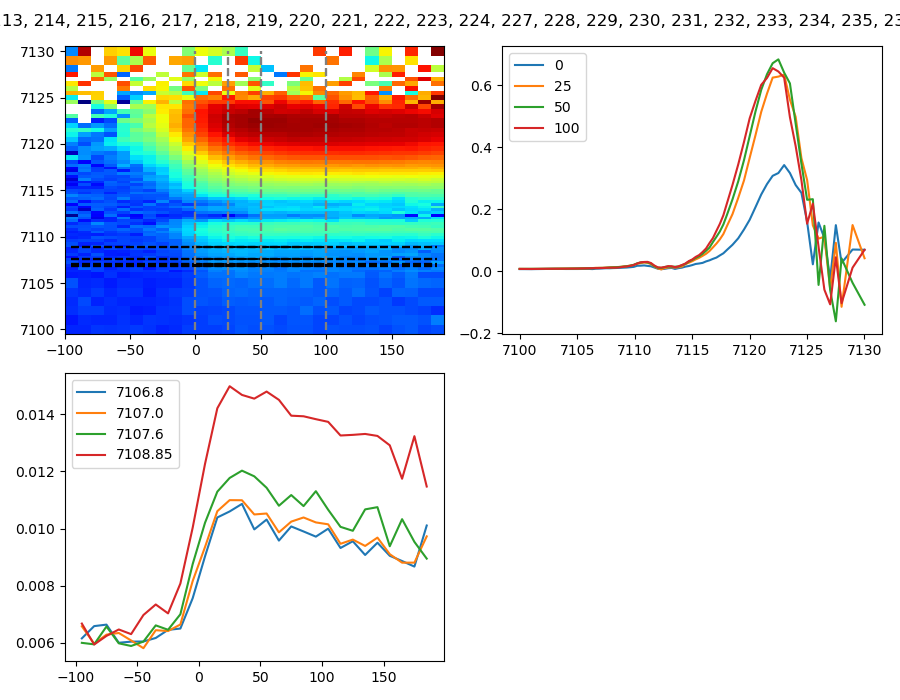

In [580]:
delay_integration = 15
energy_bin = 1

#energylist = [7121.5,7111]
energylist = [7106.8,7107.0,7107.6,7108.85]
#energylist = [7107.2,7110.3, 7111.8,7111]
#energylist = [7124]

delayslist = [0,25,50,100]

import matplotlib.colors as colors
norms = colors.LogNorm(vmin=0, vmax=1, clip=False)


f = plt.figure(figsize=(9,7))
plt.suptitle(titlestring_stack)
gs = gridspec.GridSpec(2,2, height_ratios=[2,2], width_ratios=[2,2])
ax1 = plt.subplot(gs[0,0])
#ax1.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='seismic',vmin=vmin, vmax=vmax)
#ax1.pcolormesh(Delay_fs_TT, rbk, pp_TT-baseline, cmap='jet',vmin=vmin, vmax=vmax)
ax1.pcolormesh(Delay_fs_TT, rbk, np.log(pp_TT-baseline), cmap='jet')#, norm=norms)#,vmin=vmin, vmax=vmax)
ax1.hlines(energylist, ls='--', color='black', xmin=0, xmax=100)
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[0,1])

for energy in energylist:
    index_energy = np.arange(len(rbk))[(np.array(rbk) > energy)][0]
    print (index_energy)
    ax1.hlines(energylist, ls='--', color='black', xmin=min(Delay_fs_TT), xmax=max(Delay_fs_TT))
    cut_e = np.mean(np.array(pp_TT-baseline)[np.arange(index_energy-energy_bin,index_energy+energy_bin+1),:], axis=0)
    ax2.plot(Delay_fs_TT, cut_e, label=energy)
    #ax2.plot(Delay_fs_TT, np.array(pp_TT-baseline)[index_energy], label=energy)
    ax2.legend(loc='best')

for time in delayslist:
    index_delay = np.arange(len(Delay_fs_TT))[(np.array(Delay_fs_TT) > time)][0]
    ax1.vlines(delayslist, ls='--', color='gray', ymin=min(rbk), ymax=max(rbk))
    cut_d = np.mean(np.array(pp_TT-baseline)[:,index_delay-delay_integration//binsize:index_delay+delay_integration//binsize], axis=1)
    ax3.plot(rbk, cut_d, label=time)
    #ax3.plot(rbk,np.array(pp_TT-baseline)[:,index_delay],label =time)
    #ax3.vlines(7121.5, ls='--',ymin=-0.15,ymax=0.4, color='gray')
    #ax3.vlines(7125.5, ls='--',ymin=-0.15,ymax=0.4, color='gray')

    ax3.legend(loc='best')
#ax1.set_xscale('log')
plt.tight_layout()

In [538]:
titlestring_stack

'p22250 --- [205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246]'

In [490]:
np.arange(len(rbk))[(np.array(rbk) >= 7106.9055306)]

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68])

## First cell to be run: Time-zero alignment - signal at 7124 eV

In [525]:
pgroup = 'p22250'
Loaddir_name = ''

#runlist = np.arange(41, 45)
runlist = [205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246]
#runlist = [205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,227,228,229,230,231,232]
#runlist = [205,206]
#t0_offsets = [0]*len(runlist)           # first run this to determine the offsets
t0_offsets = offset#[0]*len(runlist)   # run this later to check it is aligned
##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)
#Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

In [526]:
t0_offsets

[np.float64(7.550435693510146),
 np.float64(-8.788966173603681),
 np.float64(-14.896356861896637),
 np.float64(-9.590290147854942),
 np.float64(-13.46823234453968),
 np.float64(-14.119566244313642),
 np.float64(-23.573517693797804),
 np.float64(-10.811825759640527),
 np.float64(-12.05312325438833),
 np.float64(-18.105467003673017),
 np.float64(-16.42707608331895),
 np.float64(-11.647957906141723),
 np.float64(-9.172943607826934),
 np.float64(-15.05590812624356),
 np.float64(-14.405158534101254),
 np.float64(-4.167951956546414),
 np.float64(-15.128475930694243),
 np.float64(-12.754280031636394),
 np.float64(-10.9708372247292),
 np.float64(-9.482514927258398),
 np.float64(-0.17368003752777242),
 np.float64(6.867627408373977),
 np.float64(1.5678701697460162),
 np.float64(8.54904693536799),
 np.float64(8.670743187109778),
 np.float64(11.208573729220916),
 np.float64(5.911997094830115),
 np.float64(4.882807532908814),
 np.float64(7.1638277206101),
 np.float64(12.622596238467047),
 np.float6

# Gets the absolute time-zero shift from peak at 7124eV

In [ ]:
average_twodiodes = False
switch_diodes = False   #False #False for Diode 1, True for diode 2

quantile = 0.9

withTT = True
binsize = 10
min_delay = -75
max_delay = 250

(variable_bins_delay, numbins) = (False, 100)

energycut = 7124
#baseline = np.average(pp_TT[:,0:2], axis=1)
baseline = 0 #baseline[:, np.newaxis]

plt.figure(figsize=(10,8))
#offset = []           # uncomment for first run to check the time-zero values of each run
for index, run in enumerate(runlist):
    #print (run)
    t0_off = [t0_offsets[index]]
    data = {}
    globals().update(data)
    
    #data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist, average_twodiodes, switch_diodes)
    data, titlestring_stack = load_reduced_data_offset(pgroup, Loaddir, [run], t0_off, average_twodiodes, switch_diodes)
    #data, titlestring_stack = load_reduced_data_noPair(pgroup, Loaddir, runlist, average_twodiodes)
    
    readbacks = np.asarray(readbacks, dtype=object)
    rbk = np.array(readbacks[0], dtype=float)
    globals().update(data)

    pp_TT, err_pp, GS, ES, Delay_fs_TT, howmany = \
    Rebin_and_filter_2Dscans(data, binsize, min_delay, max_delay, quantile, rbk, withTT, threshold=0.01, n_sigma=3, varbin_t=variable_bins_delay, numbins=numbins)

    index_energy = np.arange(len(rbk))[(np.array(rbk) > energycut)][0]
    cut = np.mean(np.array(pp_TT-baseline)[index_energy-1:index_energy+1, :], axis=0)
    cut_derivative = gaussian_filter1d(cut, 1, order = 1)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(cut_derivative))
    Delay_fs_TT = Delay_fs_TT[index]
    cut_derivative=  cut_derivative[index]
    
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, cut_derivative, p0 = [0, 0.1, 50, 0])
    #print (index_energy)
   # plt.plot(Delay_fs_TT, alignment, label=run) # comment for first run
    plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green')
#    offset.append(-parameters_M2[0])           # comment after checking time-zero values for each run and run again this cell
plt.legend(loc='best')
plt.grid()
plt.tight_layout()

Run 205, Delays_stage offset by 7.550435693510146 fs
Run 205, Delays_corr offset by 7.550435693510146 fs
68 69 32
Time delay axis rebinned with TT data
22505 shots out of 33784 survived (66.61%)
Run 206, Delays_stage offset by -8.788966173603681 fs
Run 206, Delays_corr offset by -8.788966173603681 fs
68 69 32
Time delay axis rebinned with TT data
22907 shots out of 33795 survived (67.78%)
Run 207, Delays_stage offset by -14.896356861896637 fs
Run 207, Delays_corr offset by -14.896356861896637 fs
68 69 32
Time delay axis rebinned with TT data
22861 shots out of 33760 survived (67.72%)
Run 208, Delays_stage offset by -9.590290147854942 fs
Run 208, Delays_corr offset by -9.590290147854942 fs
68 69 32
Time delay axis rebinned with TT data
22810 shots out of 33771 survived (67.54%)
Run 209, Delays_stage offset by -13.46823234453968 fs
Run 209, Delays_corr offset by -13.46823234453968 fs
68 69 32
Time delay axis rebinned with TT data
23349 shots out of 33738 survived (69.21%)
Run 210, Delays

In [523]:
offset

[np.float64(7.550435693510146),
 np.float64(-8.788966173603681),
 np.float64(-14.896356861896637),
 np.float64(-9.590290147854942),
 np.float64(-13.46823234453968),
 np.float64(-14.119566244313642),
 np.float64(-23.573517693797804),
 np.float64(-10.811825759640527),
 np.float64(-12.05312325438833),
 np.float64(-18.105467003673017),
 np.float64(-16.42707608331895),
 np.float64(-11.647957906141723),
 np.float64(-9.172943607826934),
 np.float64(-15.05590812624356),
 np.float64(-14.405158534101254),
 np.float64(-4.167951956546414),
 np.float64(-15.128475930694243),
 np.float64(-12.754280031636394),
 np.float64(-10.9708372247292),
 np.float64(-9.482514927258398),
 np.float64(-0.17368003752777242),
 np.float64(6.867627408373977),
 np.float64(1.5678701697460162),
 np.float64(8.54904693536799),
 np.float64(8.670743187109778),
 np.float64(11.208573729220916),
 np.float64(5.911997094830115),
 np.float64(4.882807532908814),
 np.float64(7.1638277206101),
 np.float64(12.622596238467047),
 np.float6

## Overlay data

In [31]:
pgroup = 'p22250'
#runlist = np.arange(45, 48)
# runlist = [61,62,63,64,65,66]
runlist = [78,77] #25fs
runlist = [117,118] #0fs
runlist = [75,76,80] #50fs
runlist = [166] #300fs
runlist = [83,84,85,86,96,167] #500fs
runlist = [168] #5ps
runlist = [170] #10ps
runlist = [97,98] #15ps
runlist = [171] #50ps
#runlist = [278,322,280, 282,284,287,289,292,327,334,294,296,299, 302,309]
runlist = [63, 83]
#lab = ['0fs','25fs','50fs','150fs','300fs','500fs','750fs','1ps','2ps','3ps','5ps','10ps', '15ps', '50ps', '200ps']
lab = ['1ps','2ps','3ps']
#Loaddir_folder = '_averaged'
Loaddir_folder = ''

##############################################
#Loaddir = '/sf/alvra/data/{}/work/Reduced_data/All_shots/{}/'.format(pgroup, Loaddir_folder)
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)

titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [63, 83] from /sf/alvra/data/p22250/work/Reduced_data//


['/sf/alvra/data/p22250/work/Reduced_data/run0163-Timescan_7107p2eV_1p52uJ/run_array.npy',
 '/sf/alvra/data/p22250/work/Reduced_data/run0283-XANES_125mM_1p52uJ_150fs_002/run_array.npy']

Run 63, Delays_stage offset by 0 fs
Run 63, Delays_corr offset by 0 fs
45 46 46
22302 shots out of 22484 survived
Run 83, Delays_stage offset by 0 fs
Run 83, Delays_corr offset by 0 fs
88 89 89
43151 shots out of 43500 survived


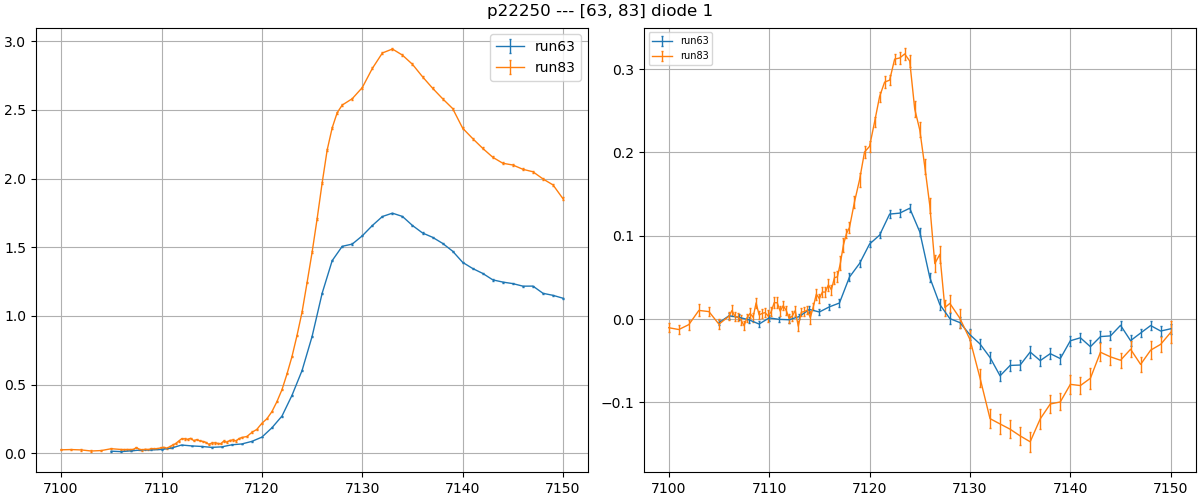

In [33]:
quantile = 1
average_twodiodes = False
switch_diodes = False #False for Diode 1, True for diode 2

t0_offset = [0]*len(runlist)
####################################################

fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle(titlestring_stack+' diode 1')

for index, run in enumerate(runlist):
    if 'averaged' not in Loaddir_folder:
        runname = 'run{}'.format(run)
        data = {}
        data, _ = load_reduced_data_offset(pgroup, Loaddir, [run], t0_offset, average_twodiodes, switch_diodes)
        globals().update(data)
        #runname = np.asarray(data['name'])[0]
        rbk = np.asarray(data['readbacks'])[0]
    
        pp_rebin, GS, ES, err_pp, err_GS, err_ES, _, _, _, _ = \
        Rebin_and_filter_energyscans_PP(data, quantile, rbk, n_sigma=3, raw=False)
        
    if 'averaged' in Loaddir_folder:
        path = glob.glob(Loaddir + '/*{}*/'.format(run))
        run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
        for key in run_array.keys():
            runname  = run_array[key]["name"].split('-')[0] + '_avg'
            GS       = run_array[key]["GS"]
            err_GS   = run_array[key]["err_GS"]
            ES       = run_array[key]["ES"]
            err_ES   = run_array[key]["err_ES"]
            pp_rebin = run_array[key]["pp"]
            err_pp   = run_array[key]["err_pp"]
            rbk      = run_array[key]["readbacks"]

#Plot with suffixes
    ax1.errorbar(rbk, GS, err_GS, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+' '+str(lab[index]))
    
    ax3.errorbar(rbk, pp_rebin, err_pp, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+' '+str(lab[index]))
    # ax1.errorbar(rbk, GS, err_GS, lw=1,markersize=0,capsize=1,capthick=1,
    #                elinewidth=1,label=runname)#+' '+str(lab[index]))

    # ax3.errorbar(rbk, pp_rebin, err_pp, lw=1,markersize=0,capsize=1,capthick=1,
    #                elinewidth=11,label=runname)#+' '+str(lab[index]))

ax1.legend()
ax1.grid()
ax3.legend(fontsize=7,loc = 'upper left')
ax3.grid()


In [16]:
path

['/sf/alvra/data/p22250/work/Reduced_data/_averaged/_averaged/run278_280_282_284_287_289_292_294_296_299_302_309_322/']

# OLD

In [49]:
pgroup = 'p21992'
Loaddir_name = 'XANES'

#runlist = np.arange(22, 23)
#runlist = [140, 146, 141, 147, 145]
runlist = [84, 90, 93, 97, 105, 116, 118, 124, 126, 132, 134, 140, 142]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scan(s), {} steps each'.format(len(runlist), int(len(DataDiode1_pump)/len(runlist))))

[84, 90, 93, 97, 105, 116, 118, 124, 126, 132, 134, 140, 142]
13 scan(s), 16 steps each


In [14]:
pgroup = 'p21992'
Loaddir_name = 'XANES'

#runlist = np.arange(22, 23)
#runlist = [140, 146, 141, 147, 145]
runlist = [93]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print (len(pump_1))
print ('{} scan(s), {} steps each'.format(len(runlist), int(len(pump_1)/len(runlist))))

[93]
6324
1 scan(s), 6324 steps each


# ONE diode: 
* [Plot averaged curves](#Ave_data)
* [Overlay different scans](#Overlay)

# TWO diodes:
* [Plot averaged curves](#Ave_data_2)
* [Overlay different scans](#Overlay2)
* [Average the 2 diodes](#average_2diodes)

<a id='Ave_data'></a>
## Average scans 1 diode

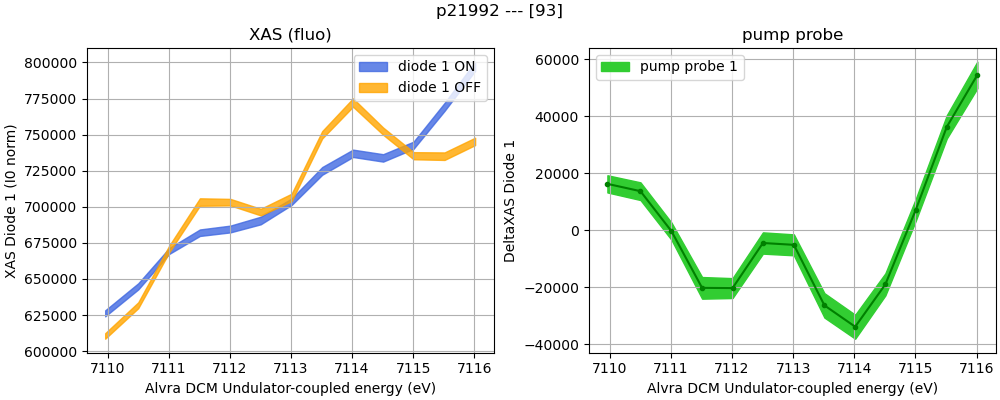

In [15]:
Energy_eV, DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1 = \
Plot_AveScans_1diode(titlestring_stack, scan, data, len(runlist), timescan=False)

## save the averaged spectra to load them overlaid

In [368]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='/das/work/p20/p20572/Camila/Reduced_XANES/Averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_1diode(reducedir, run_name, scan, 
                         average_array(DataDiode1_pump, 0), 
                         average_array(DataDiode1_unpump, 0), 
                         average_array(Pump_probe_Diode1, 0), 
                         average_array(goodshots1, 0),
                         average_array(correlation1, 0))
print (reducedir+run_name)

/das/work/p20/p20572/Camila/Reduced_XANES/Averaged/run0136-Fe3_CytC_XAS_5000fs_1.1uJ


In [249]:
np.shape(Pump_probe_Diode1)
pp_100ns = np.average(Pump_probe_Diode1, axis=0)

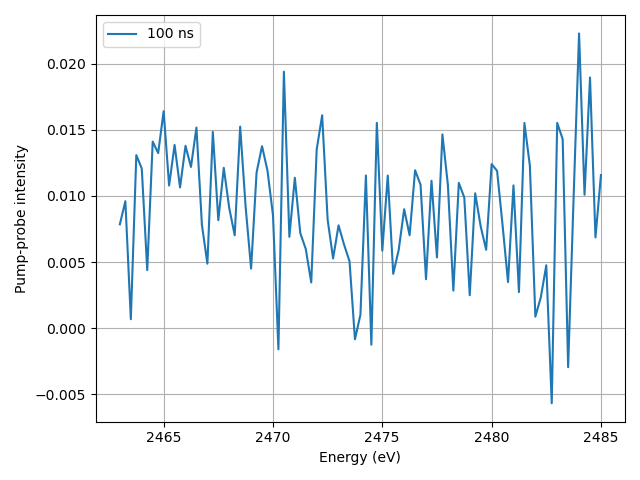

In [250]:
fig, ax = plt.subplots()

# ax.plot(Energy_eV, pp_250fs[:,0], label='250 fs')
# ax.plot(Energy_eV, pp_3ps[:,0], label='3 ps')
# ax.plot(Energy_eV, pp_25ps[:,0], label='25 ps')
ax.plot(Energy_eV, pp_100ns[:,0], label='100 ns')

# ax.fill_between(Energy_eV, pp_250fs[:,1], pp_250fs[:,2], color='b', alpha=0.3)
# ax.fill_between(Energy_eV, pp_3ps[:,1], pp_3ps[:,2], color='orange', alpha=0.3)
# ax.fill_between(Energy_eV, pp_25ps[:,1], pp_25ps[:,2], color='g', alpha=0.3)
# ax.fill_between(Energy_eV, pp_100ns[:,1], pp_100ns[:,2], color='r', alpha=0.3)

ax.set_title('')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Pump-probe intensity')

ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

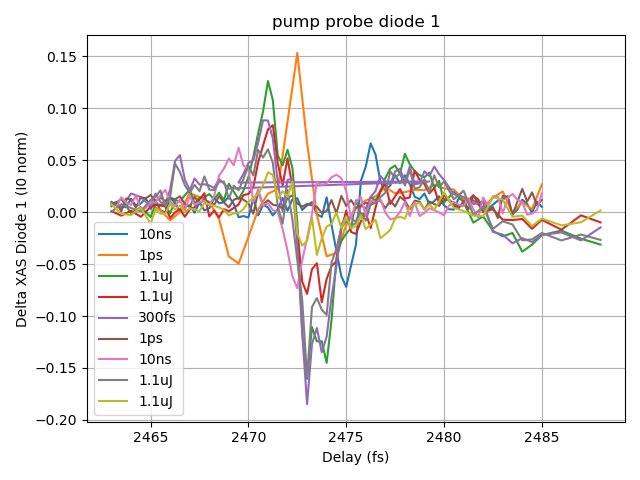

In [169]:
fig, ax1 = plt.subplots(1)

paths = glob.glob(reducedir+'*/run_array.npy')
run_arrays = [np.load(path, allow_pickle=True).item() for path in paths]

for run_array in run_arrays:
    
    for key in run_array.keys():
        delay = run_array[key]['name'].split('_')[-1]
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Energy_eV = run_array[key]["readbacks"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.plot(Energy_eV, D1p[:,0], label=runnumber)
        #ax1.plot(Energy_eV, XAS2_pump_probe[:,0], label=lab[index]+'_'+runnumber)
        # ax3 = plt.twinx(ax1)
        # ax3.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber)
        
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=delay)
        
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

ax1.set_title('pump probe diode 1')

plt.tight_layout()
plt.show()

<a id='Overlay'></a>
## Overlay different scans 1 diode

In [7]:
pgroup = 'p21992'
#runlist = np.arange(10, 12, 1)
runlist = [169, 178]
#runlist = [124, 126, 132, 134, 140, 142]

Loaddir_folder = 'XANES'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [169, 178] from /sf/alvra/data/p21992/work/Reduced_data/XANES/


['/sf/alvra/data/p21992/work/Reduced_data/XANES/run0169-MbCO_30um_XANES_500fs/run_array.npy',
 '/sf/alvra/data/p21992/work/Reduced_data/XANES/run0178-MbCO_30um_XANES_500fs/run_array.npy']

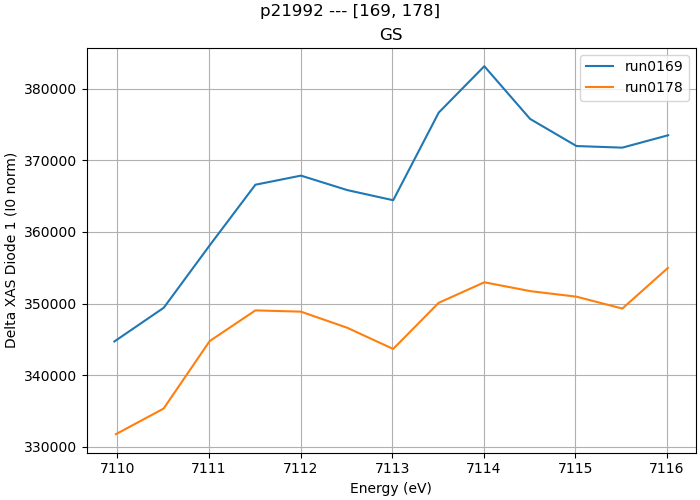

In [9]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

keys = []
#lab = ['50ps','1ps','200fs']
spec = {}
for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        #Energy_eV = run_array[key]["Energy_eV"]
        Energy_eV = run_array[key]["readbacks"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        # ax1.plot(Energy_eV, (D1u[:,0]-np.mean(D1u[:5,0]))/np.max(D1u[:,0]-np.mean(D1u[:5,0])), label=runnumber)
        #spec[runnumber] = (D1u[:,0]-np.mean(D1u[:15,0]))/np.max(D1u[:,0]-np.mean(D1u[:15,0]))
        # chosen_point = 7113
        # index_point = np.int(np.argwhere(Energy_eV > chosen_point)[0])
        spec[runnumber] = (D1u[:,0])#- D1u[0,0])
        #spec[runnumber] = (XAS1_pump_probe[:,0]-np.mean(XAS1_pump_probe[:5,0]))/np.max(XAS1_pump_probe[:,0]-np.mean(XAS1_pump_probe[:5,0]))
        ax1.plot(Energy_eV, spec[runnumber], label=runnumber) #plot ground state
        #ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber) #plot pump probe
        #ax1.plot(Energy_eV, D1u[:,0], label=runnumber) #plot ground state
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_unpump, err1_high_unpump, label=runnumber) #plot laser off

        # ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], (err1_low_pump_probe, err1_high_pump_probe), label=runnumber)
        #ax2 = plt.twinx(ax1)
        #ax2.plot(Energy_eV, D1p[:,0], label=runnumber)
        
        
# ax1.plot(Energy_eV, spec['run0041']-spec['run0071'])       
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
#ax1.set_ylim(0, 0.2e6)
#ax1.set_xlim(7110, 7120)
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('GS')
plt.show()

<a id='Ave_data_2'></a>
## Average scans 2 diodes

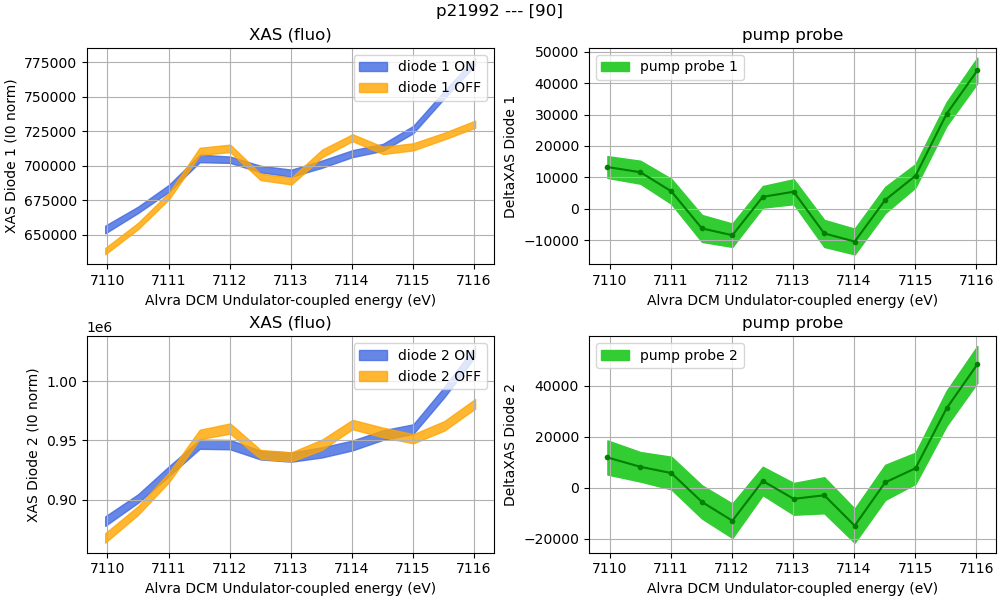

In [20]:
Energy_eV, DataDiode1_pump, DataDiode2_pump, DataDiode1_unpump, DataDiode2_unpump, Pump_probe_Diode1, Pump_probe_Diode2, goodshots1, goodshots2 = \
Plot_AveScans_2diodes(titlestring_stack, scan, data, len(runlist), timescan=False)

## save the averaged spectra to load them overlaid

In [83]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_XANES_test/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_2diodes(reducedir, run_name, scan, 
                          average_array(DataDiode1_pump, 0), 
                          average_array(DataDiode1_unpump, 0), 
                          average_array(Pump_probe_Diode1, 0), 
                          average_array(goodshots1, 0), 
                          average_array(correlation1, 0),
                          average_array(DataDiode2_pump, 0), 
                          average_array(DataDiode2_unpump, 0), 
                          average_array(Pump_probe_Diode2, 0), 
                          average_array(goodshots2, 0),
                          average_array(correlation2, 0))
print (reducedir+run_name)

NameError: name 'DataDiode2_pump' is not defined

<a id='Overlay2'></a>
## Overlay different scans 2 diodes

In [107]:
pgroup = 'p21992'
#runlist = np.arange(10, 12, 1)

runlist = [90, 93, 97, 103, 105, 118]

Loaddir_folder = 'Reduced_data/XANES'

##############################################
Loaddir = '/sf/alvra/data/{}/work/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 6 runs: [90, 93, 97, 103, 105, 118] from /sf/alvra/data/p21992/work/Reduced_data/XANES/


['/sf/alvra/data/p21992/work/Reduced_data/XANES/run0090-MbCO_XANES_preedge_500fs/run_array.npy',
 '/sf/alvra/data/p21992/work/Reduced_data/XANES/run0093-MbCO_XANES_preedge_500fs/run_array.npy',
 '/sf/alvra/data/p21992/work/Reduced_data/XANES/run0097-MbCO_XANES_500fs/run_array.npy',
 '/sf/alvra/data/p21992/work/Reduced_data/XANES/run0103-MbCO_XANES_500fs/run_array.npy',
 '/sf/alvra/data/p21992/work/Reduced_data/XANES/run0105-MbCO_XANES_500fs/run_array.npy',
 '/sf/alvra/data/p21992/work/Reduced_data/XANES/run0118-MbCO_XANES_500fs/run_array.npy']

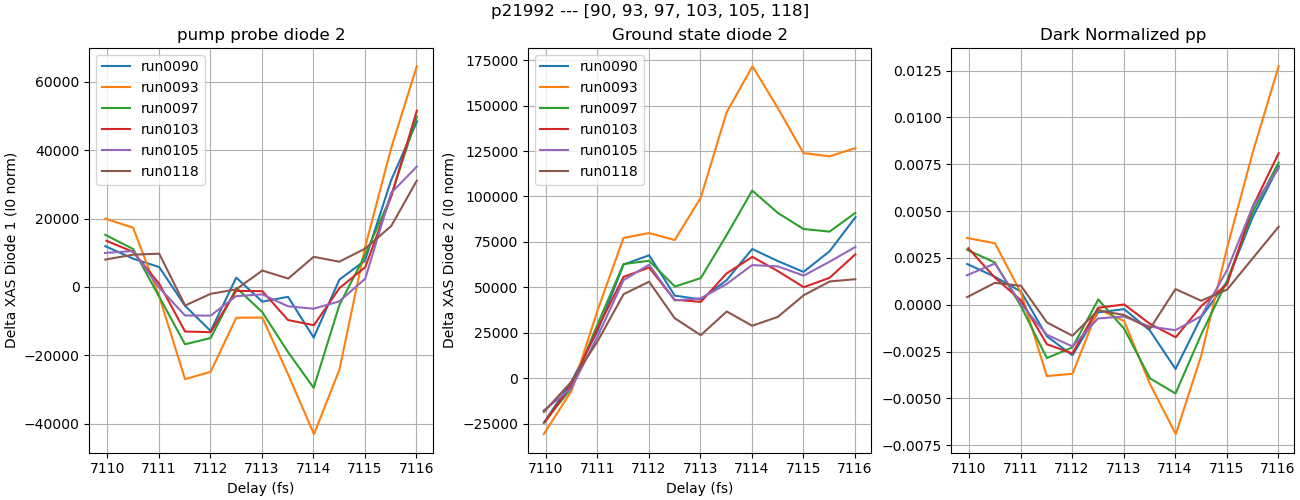

In [113]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(13, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

keys = []
#lab = ['CuDD 200fs', '500 fs', '1ps', '10ps', '50ps', '100ps']
#lab = ['100 fs t0 adjust','200fs', '1 ps', '2 ps', '10 ps', '50ps', '100 ps']
for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Energy_eV = run_array[key]["readbacks"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.plot(Energy_eV, D1p[:,0], label=runnumber)
        #ax1.plot(Energy_eV, XAS2_pump_probe[:,0], label=lab[index]+'_'+runnumber)
        # ax3 = plt.twinx(ax1)
        # ax3.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber)
        
        XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
        D2p = run_array[key]["DataDiode2_pump"]
        D2u = run_array[key]["DataDiode2_unpump"]
        gs2 = run_array[key]["goodshots2"]

        err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
        err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
        err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
        err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)

        err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
        err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
        
        
        #ax2.plot(Energy_eV, XAS2_pump_probe[:,0], label=runnumber) 
        
        #dark normalized pp 
        D2uN= D2u[:,0]/np.trapz(D2u[:,0],Energy_eV)
        D2pN= D2p[:,0]/np.trapz(D2u[:,0],Energy_eV)
        pp = (D2pN-np.mean(D2pN[:5]))-(D2uN-np.mean(D2uN[:5]))
        
        ax1.plot(Energy_eV, XAS2_pump_probe[:,0], label=runnumber)
        
        ax2.plot(Energy_eV, D2u[:,0]-np.mean(D2u[0:3,0]), label=runnumber)
        #ax2.plot(Energy_eV, D2uN-np.mean(D2uN[0:5]), label=runnumber)
        ax3.plot(Energy_eV, pp, label=runnumber)

        
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 2')
ax2.set_title('Ground state diode 2')
ax3.set_title('Dark Normalized pp')
ax3.grid()
plt.show()

<a id='average_2diodes'></a>
## Average the 2 diodes

In [23]:
Energy_eV, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring_stack, scan, data, nscans=2, timescan=False)
Energy_eV, ave_pp1 = Plot_2diodes_Averaged_1fig(titlestring_stack, scan, data, nscans=2, timescan=False)

ValueError: cannot reshape array of size 13 into shape (2,newaxis)

In [71]:
pgroup = 'p21604'
Loaddir_name = 'Reduced_XANES'

#runlist = np.arange(22, 23)
runlist = [185, 186]

##############################################
Loaddir = '/sf/alvra/data/{}/work/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scan(s), {} steps each'.format(len(runlist), int(len(DataDiode1_pump)/len(runlist))))

[185, 186]
2 scan(s), 88 steps each


### convert npy to mat files

In [29]:
pgroup = 'p20572'
Loaddir_folder = 'Reduced_XANES/Averaged'

Loaddir = '/sf/alvra/data/{}/work/Camila/{}/'.format(pgroup, Loaddir_folder)
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]

import scipy.io
f = glob.glob(Loaddir + '/{}/*.npy*'.format(run_name))[0]

#for file in f:
temp = np.load(f, allow_pickle=True)
mdic = {run_name.split('-')[0]: temp,}
fname = file.split('/')[-1].split('.')[0]
path = (Loaddir + '/Matlab/')
os.makedirs(path, exist_ok=True)
#print (path + '/' + fname)
scipy.io.savemat(path + run_name + '.mat', mdic)

IndexError: list index out of range

In [378]:
f

'/sf/alvra/data/p20572/work/Camila/Reduced_XANES/Averaged//run0056-Fe2_CytC_XAS_5000fs_1.1uJ/run_array.npy'